In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
import sklearn.neighbors
from lib.scikitComponents import *
import itertools
import collections
from lib.scikitComponents import pipelines
import scipy.stats

## Data preprocessing

In [3]:
# Load in the previously created corpus and dictionary of scraped sites
Datas = collections.namedtuple('Datas', ['dictionary', 'corpus', 'meta_corpus', 'dmoz_data'])
unstemmed = Datas(*jsoncorpus.load_or_create('docs/sites.jl'))
stemmed = Datas(*jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_"))

Done.
Done.


In [13]:
def merge_corpus(a, b):
    a = dict(a)
    b = dict(b)
    for k in b:
        old = a.get(k, 0)
        a[k] = old + b[k]
    return [(k, a[k]) for k in a]




def preprocess(data):
    merged_corpus = [merge_corpus(a, b) for a, b in zip(data.corpus, data.meta_corpus)]
    # Set up array of input data
    X = zip(list(data.corpus), list(data.meta_corpus), merged_corpus)
    # Link topics to URLs
    meta = list(zip(data.dmoz_data['urls'], data.dmoz_data['dmoz_categories']))
    # Encode class labels
    classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(data.dmoz_data['dmoz_categories'])
    return (X, meta, classes, top_categories, dmoz_encoder)

X, meta, classes, top_categories, dmoz_encoder = preprocess(stemmed)

In [14]:
verbosity = 3

## Boxplots for different representation combinations

In [15]:
dictionary = stemmed.dictionary


In [16]:
scores = [
    sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5, verbose=verbosity, scoring='f1_weighted')
    for clf in clfs]

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.562255 -   1.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.560963 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.579253 -   2.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.560499 -   1.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.501424 -   1.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


## Stemming comparison

In [159]:
X_s, meta_s, classes_s, top_categories_s, dmoz_encoder_s = preprocess(stemmed)
X_u, meta_u, classes_u, top_categories_u, dmoz_encoder_u = preprocess(unstemmed)

In [184]:
clf_s = pipelines.make_classifier(stemmed.dictionary, body_kind='tfidf', meta_kind='tfidf', classifier = 'svc')
clf_u = pipelines.make_classifier(unstemmed.dictionary, body_kind='tfidf', meta_kind='tfidf', classifier = 'svc')
clf_s.name = "stemmed " + clf_s.name
score_s = sklearn.cross_validation.cross_val_score(clf_s, X_s, classes_s, cv=5, verbose=verbosity, scoring='f1_weighted')
score_u = sklearn.cross_validation.cross_val_score(clf_u, X_u, classes_u, cv=5, verbose=verbosity, scoring='f1_weighted')

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.551907 -   2.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.554505 -   2.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.603026 -   2.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.563891 -   2.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.495385 -   2.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.495742 -   3.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.526985 -   3.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.558660 -   4.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.528004 -   2.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.465684 -   2.7s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.8s finished


In [244]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

In [1]:
k = 3
makeboxplot(scores[-k:], clfs[-k:])
print_pvalue([c.name for c in clfs[-k:]], scores[-k:])
plt.savefig('box_meta_or_body.pdf', bbox_inches='tight')

NameError: name 'makeboxplot' is not defined

[Stemming] vs [Not]: p-value = 13.6963300709%


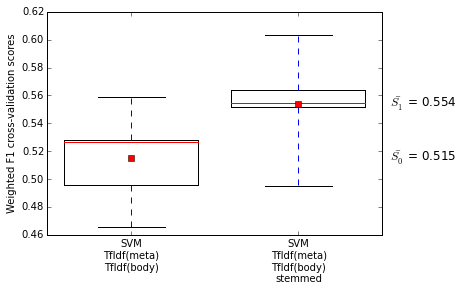

In [422]:
makeboxplot([score_s, score_u], [clf_s, clf_u], )
print_pvalue(["Stemming", "Not"], [score_s, score_u])
plt.savefig('box_stemming.pdf', bbox_inches='tight')

In [29]:
cclfs = np.array([
    pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='svc'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='trees'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='trees'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='trees'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='tfidf', classifier='nb'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='lda', classifier='nb'),
     pipelines.make_classifier(dictionary, corp_type='both', feature='count', classifier='nb'),
])

In [30]:
cscores = [sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5, verbose=verbosity, scoring='f1_weighted') 
 for clf in cclfs]

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.562255 -   1.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.560963 -   1.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.579253 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.560499 -   1.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.501424 -   1.5s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.333287 -  11.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.262790 -  13.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.339910 -  12.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.329673 -  12.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.316808 -  13.2s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.456450 -   0.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.477443 -   0.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.492793 -   0.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.436384 -   0.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.446192 -   0.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.446680 -  12.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.426409 -  13.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.494589 -  12.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.433139 -  12.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.394221 -  15.4s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   12.1s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.307584 -  13.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.345321 -  12.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.357412 -  12.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.392486 -  13.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.325662 -  12.1s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.389106 -   6.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.389572 -   5.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.438993 -   6.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.405994 -   7.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.384531 -   6.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.2s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.306950 -   1.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.320029 -   1.9s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.360733 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.337536 -   1.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.301682 -   1.9s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.3s finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.149193 -  14.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.128999 -  13.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.180112 -  16.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.138146 -  13.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.101340 -  15.0s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished



[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.445791 -   0.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.441340 -   0.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.515810 -   0.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.470214 -   0.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.496459 -   0.5s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


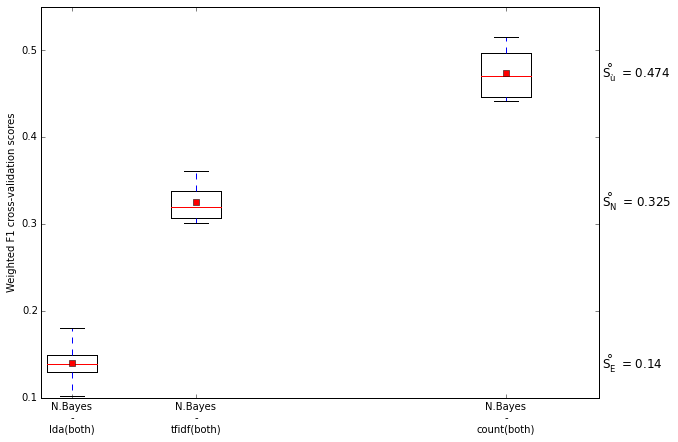

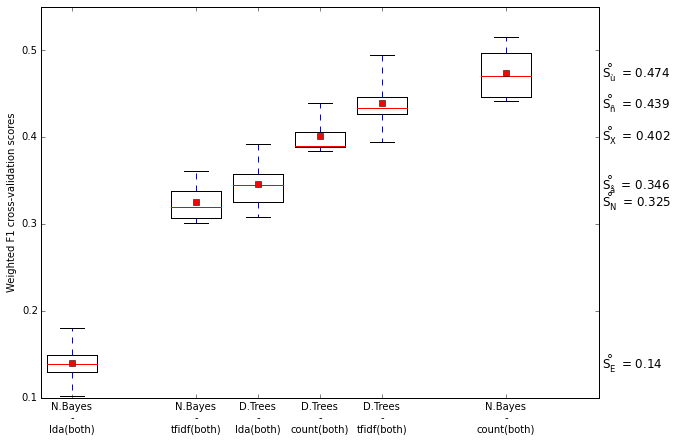

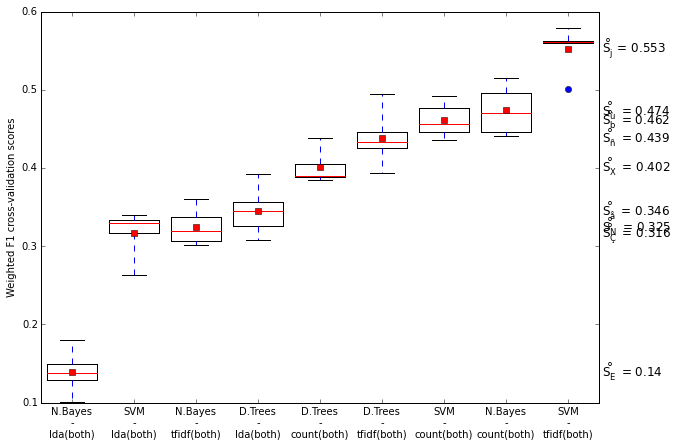

In [33]:
def newline_name(name):
    return "\n".join(reversed(name.split()))

def makeboxplot(scores, clfs, ylabel='Weighted F1 cross-validation scores', figsize=None, inds=None, maxp=None):
    inds = inds or range(len(clfs))
    sortinds = np.argsort(np.mean(np.array(scores).T, axis=0))
    scores_sorted = np.array(scores)[sortinds, :].T[:, inds]
    labels_sorted = np.array([newline_name(clf.name) for clf in clfs])[sortinds][inds]
    
    
    if figsize:
        plt.figure(figsize=figsize)
    
    box_params = dict(showmeans=True,widths=0.8, flierprops=dict(marker='o'), patch_artist=True)
    
    maxp = maxp or max(positions)+1
    box = plt.boxplot(scores_sorted, labels = labels_sorted, whis=10, positions = np.array(inds)+1, **box_params)
    plt.ylabel(ylabel)
    plt.xlim((0.5, maxp+0.5))
    for i, s in enumerate(scores_sorted.T):
        text = "$\\bar{{S_{}}}$ = {:.3}".format(inds[i], np.mean(s))
        tx = maxp+0.55
        ty = np.mean(s)
        plt.text(tx, ty, text, va='center', fontsize=12)
        props = dict(color='gray', shrink=0.05, frac=0.12/float
                     (len(clfs) - i), width=0.5, headwidth=3)
    
def print_pvalue(names, scores):
    for a, b in itertools.combinations(zip(names, scores), 2):
        aname, ascore = a
        bname, bscore = b
        pvalue = scipy.stats.ttest_ind(ascore, bscore, equal_var=False)[1]
        print "[{}] vs [{}]: p-value = {}%".format(aname, bname, pvalue)

inds = [0, 2, 7]
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (10, 7), inds = inds, maxp=9)
plt.savefig('box_full_1.pdf', bbox_inches='tight')
inds = inds + [3, 4, 5]
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (10, 7), inds = inds, maxp=9)
plt.savefig('box_full_2.pdf', bbox_inches='tight')
inds = inds + [1, 6, 8]
makeboxplot(np.array(cscores), np.array(cclfs), figsize = (10, 7), inds = inds, maxp=9)
plt.savefig('box_full_3.pdf', bbox_inches='tight')



In [32]:
cclfs[4].fit(X, classes)


Pipeline(steps=[('selection', ItemPicker(index=2)), ('feature', Pipeline(steps=[('lda_model', LDAModel(dictionary=<gensim.corpora.dictionary.Dictionary object at 0x10dac3310>,
     num_topics=20)), ('matrix_builder', TopicMatrixBuilder(keep_all=False, num_topics=20, topic_min_members=0))])), ('classifier', E..._estimators=100, n_jobs=4,
           oob_score=True, random_state=0, verbose=0, warm_start=False))])

In [585]:
words = []
for c in range(14):
    weights = cclfs[4].steps[1][1].coef_[c]
    inds = np.argsort(weights)[::-1]
    best = [dictionary[i] for i in inds][:9]
    words.append(best)
    print "\\item \\textbf{{{}}}: {}".format(dmoz_encoder.inverse_transform(c), ", ".join(best))
#np.array(words)

\item \textbf{arts}: art, artist, award, design, costum, font, film, tattoo, literari
\item \textbf{business}: busi, compani, product, investor, drill, sustain, financi, industri, nanni
\item \textbf{computers}: comput, file, usenet, softwar, bb, algorithm, robot, window, emul
\item \textbf{games}: game, dice, puzzl, rpg, wargam, miniatur, stack, diplomaci, parti
\item \textbf{health}: health, pharmaci, addict, diseas, drug, osha, age, veterinari, care
\item \textbf{home}: garden, diy, apart, toy, consum, clean, move, kitchen, plant
\item \textbf{kids and teens}: kid, parent, teacher, clipart, fun, homeschool, children, disney, manor
\item \textbf{news}: newspap, netanyahu, weather, obama, news, radio, iran, polit, forecast
\item \textbf{recreation}: hike, lock, climb, bird, cave, travel, camp, pet, whip
\item \textbf{reference}: librari, knot, dictionari, isbn, thesauru, biographi, word, encyclopedia, answer
\item \textbf{regional}: popul, countri, cia, island, nat, territori, geograp

In [548]:
dictionary[4]

u'yellow'